<a href="https://colab.research.google.com/github/fabiobento/dnn-course-2024-1/blob/main/00_course_folder/cert_prof_time_series/class_04/TS%20-%20W4%20-%2004%20-%20LSTM%20(Laborat%C3%B3rio%201).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

adaptado de [Certificado Profissional Desenvolvedor do TensorFlow](https://www.coursera.org/professional-certificates/tensorflow-in-practice) de [Laurence Moroney](https://laurencemoroney.com/)

# Uso de convoluções com LSTMs

Neste laboratório, você usará como base os modelos RNN criados em notebooks anteriores e acrescentará uma camada de convolução a eles.

Como você viu em cursos anteriores, os filtros de convolução também podem capturar recursos de sequências, portanto, é bom experimentá-los ao explorar as arquiteturas de modelos. Vamos começar!

## Importações

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-04-13 19:40:46.196314: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-13 19:40:46.406492: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 19:40:46.406514: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 19:40:46.407641: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-13 19:40:46.493517: I tensorflow/core/platform/cpu_feature_g

## Utilitários

Você plotará o MAE e a perda posteriormente, portanto, o `plot_series()` foi estendido para ter mais funcionalidade de rotulagem. Os utilitários para gerar os dados sintéticos são os mesmos dos laboratórios anteriores.

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualiza dados de séries temporais

    Args:
      x (matriz de int) - contém valores para o eixo x
      y (matriz de int ou tupla de matrizes) - contém os valores para o eixo y
      format (string) - estilo de linha ao plotar o gráfico
      start (int) - primeiro passo de tempo a ser plotado
      end (int) - último passo de tempo a ser plotado
      title (string) - título do gráfico
      xlabel (string) - rótulo do eixo x
      ylabel (string) - rótulo do eixo y
      legend (lista de strings) - legenda para o gráfico
    """

    # Configurar as dimensões da figura do gráfico
    plt.figure(figsize=(10, 6))

    # Verificar se há mais de duas séries para plotar
    if type(y) is tuple:

      # Fazer um loop sobre os elementos y
      for y_curr in y:

        # Plote os valores x e y atuais
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plote os valores x e y
      plt.plot(x[start:end], y[start:end], format)

    # Rotular o eixo x
    plt.xlabel(xlabel)

    # Rotular o eixo y
    plt.ylabel(ylabel)

    # Configurar a legenda
    if legend:
      plt.legend(legend)

    # Definir o título
    plt.title(title)

    # Sobrepor uma grade no gráfico
    plt.grid(True)

    # Desenhe o gráfico na tela
    plt.show()

def trend(time, slope=0):
    """
    Gera dados sintéticos que seguem uma linha reta com um valor de inclinação.

    Args:
      time (vetor de int) - contém as etapas de tempo
      slope (float) - determina a direção e a inclinação da linha

    Retorna:
      series (matriz de float) - medições que seguem uma linha reta
    """

    # Calcula a série linear dada a inclinação
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Apenas um padrão arbitrário, você pode alterá-lo se desejar

    Args:
      season_time (matriz de float) - contém as medições por etapa de tempo

    Retorna:
      data_pattern (matriz de float) - contém os valores de medição revisados de acordo com o padrão definido.
                                  de acordo com o padrão definido
    """

    # Gerar os valores usando um padrão arbitrário
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repete o mesmo padrão em cada período

    Args:
      time (matriz de int) - contém as etapas de tempo
      period (int) - número de etapas de tempo antes da repetição do padrão
      amplitude (int) - valor de pico medido em um período
      phase (int) - número de etapas de tempo para deslocar os valores medidos

    Retorna:
      data_pattern (matriz de float) - dados sazonais dimensionados pela amplitude definida
    """

    # Definir os valores medidos por período
    season_time = ((time + phase) % period) / period

    # Gera os dados sazonais dimensionados pela amplitude definida
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Gera um sinal ruidoso normalmente distribuído

    Args:
      time (matriz de int) - contém as etapas de tempo
      noise_level (float) - fator de escala para o sinal gerado
      seed (int) - semente do gerador de números para repetibilidade

    Retorna:
      noise (matriz de float) - o sinal ruidoso
    """

    # Inicializar o gerador de números aleatórios
    rnd = np.random.RandomState(seed)

    # Gerar um número aleatório para cada etapa de tempo e dimensionar pelo nível de ruído
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Gerar os dados sintéticos

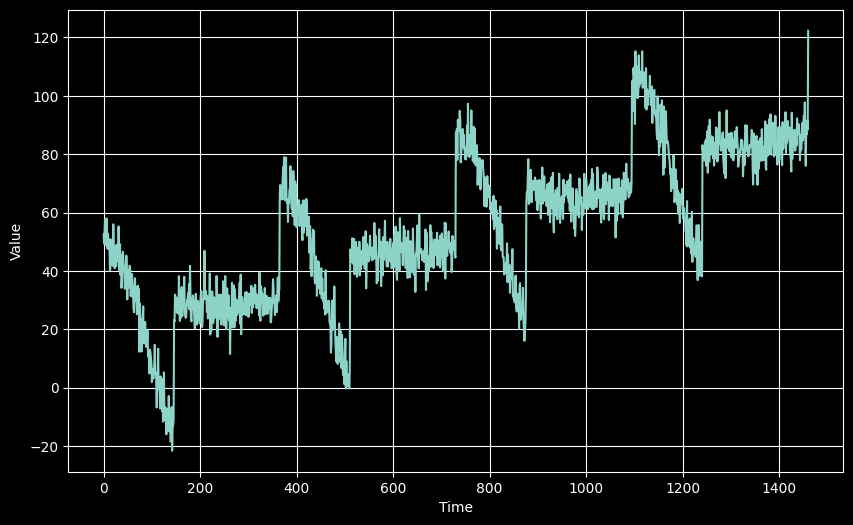

In [3]:
# Hyperparâmetros
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Criar a série
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Atualizar com ruído
series += noise(time, noise_level, seed=42)

# Plotar os resultados
plot_series(time, series, xlabel='Time', ylabel='Value')

## Dividir o conjunto de dados

In [4]:
# Definir o tempo de divisão
split_time = 1000

# Obter o conjunto de treino
time_train = time[:split_time]
x_train = series[:split_time]

# Obter o conjunto de validação
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preparar recursos e rótulos

Conforme mencionado nas palestras, você pode experimentar diferentes tamanhos de lote aqui e ver como isso afeta seus resultados.

In [5]:
# Hyperparâmetros
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Gera janelas de conjunto de dados

    Args:
      series (array of float) - contém os valores da série temporal
      window_size (int) - o número de etapas de tempo para calcular a média
      batch_size (int) - o tamanho do lote
      shuffle_buffer(int) - tamanho do buffer a ser usado para o método shuffle

    Retorna:
      dataset (TF Dataset) - Conjunto de dados TF contendo janelas de tempo
    """

    # Gerar um conjunto de dados TF a partir dos valores da série
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Janela de dados, mas só pega aqueles com o tamanho especificado
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Achatar as janelas, colocando seus elementos em um único lote
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Criar tuplas com recursos e rótulos
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Embaralhar as janelas
    dataset = dataset.shuffle(shuffle_buffer)

    # Criar lotes de janelas
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [7]:
# Gerar as janelas do conjunto de dados
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-04-13 19:40:48.568304: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 19:40:48.585960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 19:40:48.586096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Construir o modelo

Aqui está a arquitetura do modelo que você usará. Ela é muito semelhante à última RNN que você construiu, mas com a camada [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) na entrada. Um [argumento](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D#args) importante aqui é o `padding`. Para dados de série temporal, é uma boa prática não permitir que os cálculos de uma determinada etapa de tempo sejam afetados por valores futuros. Por exemplo:
* Digamos que você tenha uma pequena janela de série temporal com os seguintes valores: `[1, 2, 3, 4, 5]`. Isso significa que o valor `1` está em `t=0`, `2` está em `t=1`, etc.
* Se você tiver um kernel 1D de tamanho `3`, a primeira convolução será para os valores em `[1, 2, 3]`, que são valores de `t=0` a `t=2`.
* Quando você passa isso para o primeiro intervalo de tempo do `LSTM` após a convolução, significa que o valor em `t=0` do LSTM depende de `t=1` e `t=2`, que são valores futuros.
* Para dados de série temporal, você deseja que os cálculos dependam apenas das etapas de tempo atuais e anteriores.
* Uma maneira de fazer isso é preencher a matriz dependendo do tamanho do kernel e do stride. Para um tamanho de kernel de 3 e stride de 1, a janela pode ser preenchida da seguinte forma: `[0, 0, 1, 2, 3, 4, 5]`. O `1` ainda está em `t=0` e dois zeros são anexados para simular valores no passado.
* Dessa forma, a primeira cadeia estará em `[0, 0, 1]` e não conterá nenhum valor futuro quando for passada para as camadas subsequentes.

A camada `Conv1D` faz esse tipo de preenchimento definindo `padding=causal` e você verá isso abaixo.

In [8]:
# Redefinir estados gerados pelo Keras
tf.keras.backend.clear_session()

# COnstruir o modelo
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Imprimir sumário do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66369 (259.25 KB)
Trainable params: 66369 (259.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Ajuste a taxa de aprendizado

Nos laboratórios anteriores, você usou modelos diferentes para ajuste e treinamento. Essa é uma abordagem válida, mas você também pode usar o mesmo modelo para ambos. Antes de fazer o ajuste, você pode usar o método [`get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights) para poder redefini-lo posteriormente.

In [9]:
# Obter pesos iniciais
init_weights = model.get_weights()

After that, you can tune the model as usual.

In [10]:
# Definir o agendador de taxa de aprendizado
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Inicializar o otimizador
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Definir os parâmetros de treinamento
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Treinar o modelo
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


2024-04-13 19:40:50.814355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-04-13 19:40:51.623722: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x79383c1517a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-13 19:40:51.623742: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-04-13 19:40:51.669114: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 [==============================] - 3s 8ms/step - loss: 34.3218 - lr: 1.0000e-08
Epoch 2/100
45/62 [====================>.........] - ETA: 0s - loss: 28.7041

2024-04-13 19:40:52.321802: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17929118386081491389
2024-04-13 19:40:52.321834: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12858483052595336117


62/62 [==============================] - 0s 4ms/step - loss: 27.9182 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 1s 8ms/step - loss: 24.5925 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 1s 8ms/step - loss: 21.5884 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 1s 8ms/step - loss: 18.0164 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 0s 5ms/step - loss: 13.7275 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 11.6704 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 0s 5ms/step - loss: 9.8775 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 0s 4ms/step - loss: 8.4081 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 0s 5ms/step - loss: 7.6505 - lr: 2.8184e-08
Epoch 11/100
62/62 [==============================] - 0s 4ms/step - loss: 7.1837 - lr: 3.1623e-08
Epoch 12/100
62/62 [==============

(1e-08, 0.001, 0.0, 50.0)

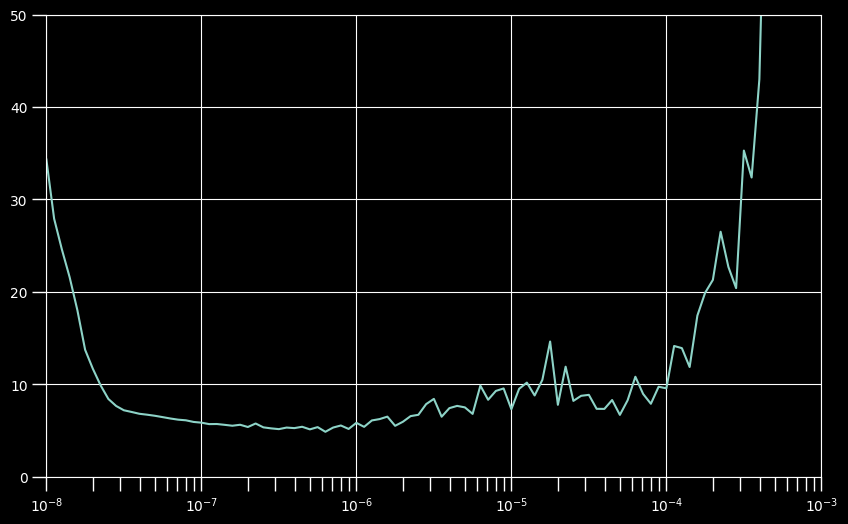

In [11]:
# Definir a matriz de taxa de aprendizado
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Definir o tamanho da figura
plt.figure(figsize=(10, 6))

# Definir a grade
plt.grid(True)

# Plotar a perda em escala logarítmica
plt.semilogx(lrs, history.history["loss"])

# Aumentar o tamanho dos tickmarks
plt.tick_params('both', length=10, width=1, which='both')

# Definir os limites do gráfico
plt.axis([1e-8, 1e-3, 0, 50])

## Treinar o modelo

Para redefinir os pesos, basta chamar a função [`set_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#set_weights) e passar os pesos salvos anteriormente.

In [12]:
# Redefinir estados gerados pelo Keras
tf.keras.backend.clear_session()

# Redefinir os pesos
model.set_weights(init_weights)

Em seguida, você pode definir os parâmetros de treinamento e iniciar o treinamento.

In [13]:
# Definir a taxa de aprendizado
learning_rate = 1e-7

# Definir o otimizador
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Definir os parâmetros de treinamento
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [14]:
# Treinar o modelo
history = model.fit(train_set,epochs=500)

Epoch 1/500
62/62 [==============================] - 2s 5ms/step - loss: 23.2830 - mae: 23.7791
Epoch 2/500
26/62 [===========>..................] - ETA: 0s - loss: 10.1348 - mae: 10.6206

2024-04-13 19:41:38.399553: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17929118386081491389
2024-04-13 19:41:38.399608: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12858483052595336117


62/62 [==============================] - 0s 5ms/step - loss: 8.8577 - mae: 9.3416
Epoch 3/500
62/62 [==============================] - 1s 8ms/step - loss: 7.0605 - mae: 7.5428
Epoch 4/500
62/62 [==============================] - 0s 4ms/step - loss: 6.6804 - mae: 7.1603
Epoch 5/500
62/62 [==============================] - 0s 4ms/step - loss: 6.2919 - mae: 6.7724
Epoch 6/500
62/62 [==============================] - 0s 7ms/step - loss: 6.1498 - mae: 6.6335
Epoch 7/500
62/62 [==============================] - 0s 6ms/step - loss: 6.1571 - mae: 6.6421
Epoch 8/500
62/62 [==============================] - 1s 8ms/step - loss: 5.8115 - mae: 6.2914
Epoch 9/500
62/62 [==============================] - 0s 5ms/step - loss: 5.7568 - mae: 6.2359
Epoch 10/500
62/62 [==============================] - 1s 8ms/step - loss: 5.7569 - mae: 6.2388
Epoch 11/500
62/62 [==============================] - 0s 5ms/step - loss: 5.7593 - mae: 6.2395
Epoch 12/500
62/62 [==============================] - 1s 9ms/step - lo

O treinamento pode ser um pouco instável, especialmente quando os pesos começam a convergir, portanto, convém visualizá-lo para ver se ainda há tendência de queda. As épocas anteriores podem dominar o gráfico, portanto, também é bom dar zoom nas partes posteriores do treinamento para observar adequadamente os parâmetros. O código abaixo visualiza o `mae` e a `perda` para todas as épocas e também aumenta o zoom nos últimos 80%.

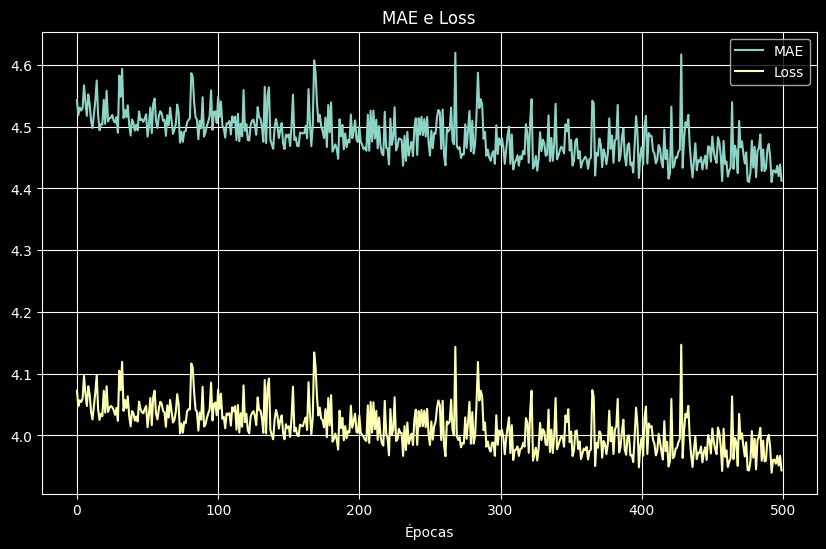

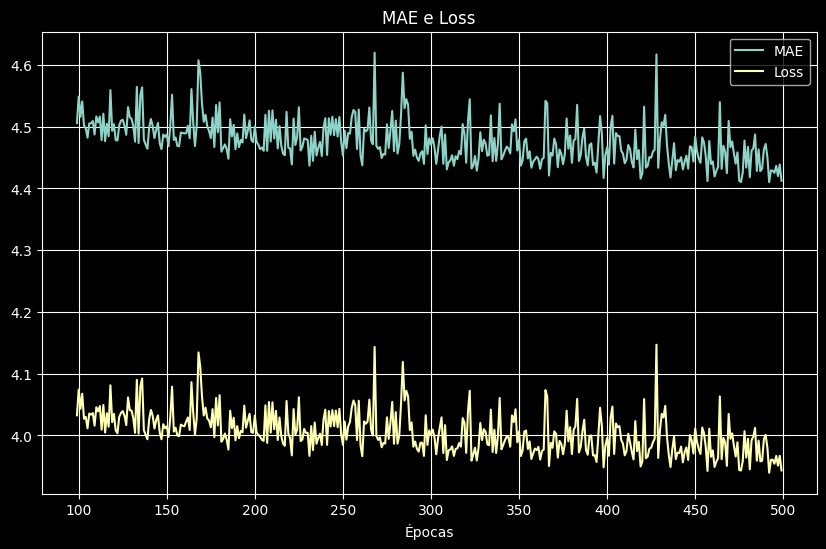

In [28]:
# Obtenha a MAE e a perda do registro histórico
mae=history.history['mae']
loss=history.history['loss']

# Obter o número de épocas
epochs=range(len(loss))

# Plotar mae e loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE e Loss',
    xlabel='Épocas',
    legend=['MAE', 'Loss']
    )

# Plote apenas os últimos 80% das épocas
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# # Plotar perdas e ganhos com zoom
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE e Loss',
    xlabel='Épocas',
    legend=['MAE', 'Loss']
    )

## Previsão do modelo

Quando o treinamento estiver concluído, você poderá gerar as previsões do modelo e plotá-las em relação ao conjunto de validação.

In [16]:
def model_forecast(model, series, window_size, batch_size):
    """Usa um modelo de entrada para gerar previsões em janelas de dados

    Args:
      model (TF Keras Model) - modelo que aceita janelas de dados
      series (matriz de float) - contém os valores da série temporal
      window_size (int) - o número de etapas de tempo a serem incluídas na janela
      batch_size (int) - o tamanho do lote

    Retorna:
      forecast (matriz numpy) - matriz que contém as previsões
    """

    # Gerar um conjunto de dados TF a partir dos valores da série
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Janela de dados, mas só pega aqueles com o tamanho especificado
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Achatar as janelas, colocando seus elementos em um único lote
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Criar lotes de janelas
    dataset = dataset.batch(batch_size).prefetch(1)

    # Obter previsões sobre todo o banco de dados
    forecast = model.predict(dataset)

    return forecast

29/29 [==============================] - 0s 2ms/step


2024-04-13 19:45:28.569341: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1667202457573530435


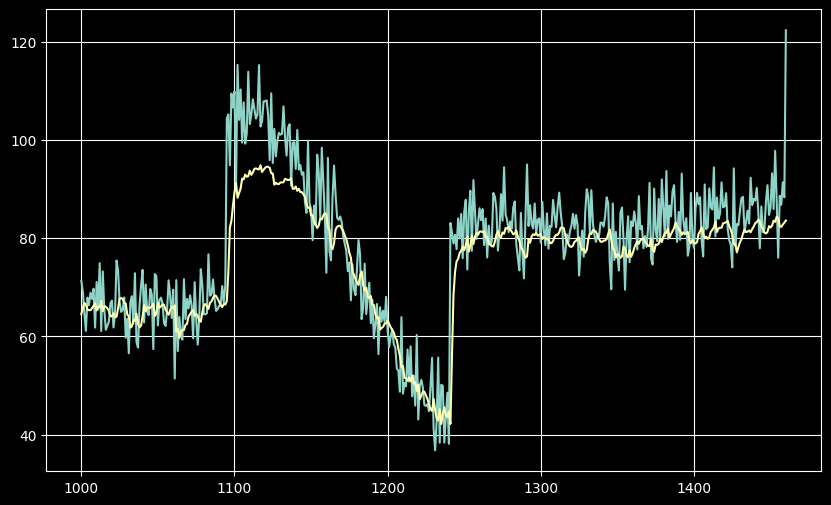

In [17]:
# Reduzir a série original
forecast_series = series[split_time-window_size:-1]

# Use a função auxiliar para gerar previsões
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Solte os eixos unidimensionais
results = forecast.squeeze()

# Plotar os resultados
plot_series(time_valid, (x_valid, results))

Em seguida, você pode calcular as métricas como de costume.

In [18]:
## Calcular o MAE e o MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

61.191124
5.709347


## Adição de um _callback_ para interrupção antecipada

Nesta seção opcional, você adicionará um retorno de chamada para interromper o treinamento quando uma métrica for atingida. Você já fez isso no antes e agora seria um bom momento para revisar.

Primeiro, você precisa preparar um conjunto de validação que o modelo possa usar e monitorar. Conforme mostrado no laboratório anterior, você pode usar a função `windowed_dataset()` para preparar esse conjunto.

In [19]:
# Gerar janelas de dados a partir do conjunto de validação
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

Você pode redefinir os pesos do modelo ou simplesmente continuar de onde parou.

In [20]:
# Descomente se você quiser redefinir os peso
# model.set_weights(init_weights)

Em seguida, você definirá uma função de retorno de chamada que será executada a cada final de época. Dentro dela, você definirá a condição para interromper o treinamento. Para este laboratório, você definirá a interrupção quando o `val_mae` for menor que `5,2`.

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Interrompe o treinamento quando uma determinada métrica é atingida

    Args:
      epoch (integer) - índice de época (obrigatório, mas não utilizado na definição de função abaixo)
      logs (dict) - resultados da métrica da época de treinamento
    '''

    # Verificar o conjunto de validação MAE
    if(logs.get('val_mae') < 5.2):

      # Parar se o limite for atingido
      print("\nO valor MAE necessário foi atingido, portanto, o treinamento está sendo encerrado!")
      self.model.stop_training = True

# Instanciar a classe
callbacks = myCallback()

Lembre-se de definir uma taxa de aprendizado apropriada aqui. Se você estiver começando com pesos aleatórios, talvez queira usar a mesma taxa usada anteriormente. No entanto, se você não redefiniu os pesos, poderá usar uma taxa de aprendizagem mais baixa para que o modelo possa aprender melhor. Se tudo correr bem, o treinamento será interrompido antes que o conjunto de 500 épocas seja concluído.

In [22]:
# Definir a taxa de aprendizado
learning_rate = 4e-8

# Definir o otimizador
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Definir os parâmetros de treinamento
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Treinar o modelo
history = model.fit(train_set, epochs=500, validation_data=val_set, callbacks=[callbacks])

Epoch 1/500
     61/Unknown - 2s 7ms/step - loss: 4.0570 - mae: 4.5275

2024-04-13 19:45:31.002136: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17929118386081491389
2024-04-13 19:45:31.002252: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12858483052595336117


62/62 [==============================] - 3s 16ms/step - loss: 4.0723 - mae: 4.5430 - val_loss: 5.1575 - val_mae: 5.6390
Epoch 2/500
14/62 [=====>........................] - ETA: 0s - loss: 3.7390 - mae: 4.2127

2024-04-13 19:45:31.480287: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1667202457573530435


62/62 [==============================] - 1s 9ms/step - loss: 4.0476 - mae: 4.5189 - val_loss: 5.1464 - val_mae: 5.6280
Epoch 3/500
62/62 [==============================] - 1s 8ms/step - loss: 4.0568 - mae: 4.5308 - val_loss: 5.0038 - val_mae: 5.4817
Epoch 4/500
62/62 [==============================] - 0s 6ms/step - loss: 4.0542 - mae: 4.5261 - val_loss: 5.2559 - val_mae: 5.7380
Epoch 5/500
62/62 [==============================] - 1s 10ms/step - loss: 4.0599 - mae: 4.5302 - val_loss: 5.0121 - val_mae: 5.4904
Epoch 6/500
62/62 [==============================] - 1s 9ms/step - loss: 4.0963 - mae: 4.5670 - val_loss: 5.5060 - val_mae: 5.9865
Epoch 7/500
62/62 [==============================] - 0s 6ms/step - loss: 4.0674 - mae: 4.5398 - val_loss: 5.2488 - val_mae: 5.7307
Epoch 8/500
62/62 [==============================] - 0s 5ms/step - loss: 4.0476 - mae: 4.5175 - val_loss: 5.3738 - val_mae: 5.8572
Epoch 9/500
62/62 [==============================] - 1s 8ms/step - loss: 4.0796 - mae: 4.5523 

Na prática, você normalmente tem um conjunto de testes separado para avaliar em relação a dados não vistos. No entanto, para este exercício, o conjunto de dados já é muito pequeno, portanto, vamos usar o mesmo conjunto de validação apenas para verificar se os resultados são comparáveis aos que você obteve anteriormente.

29/29 [==============================] - 0s 1ms/step


2024-04-13 19:50:00.498536: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1667202457573530435


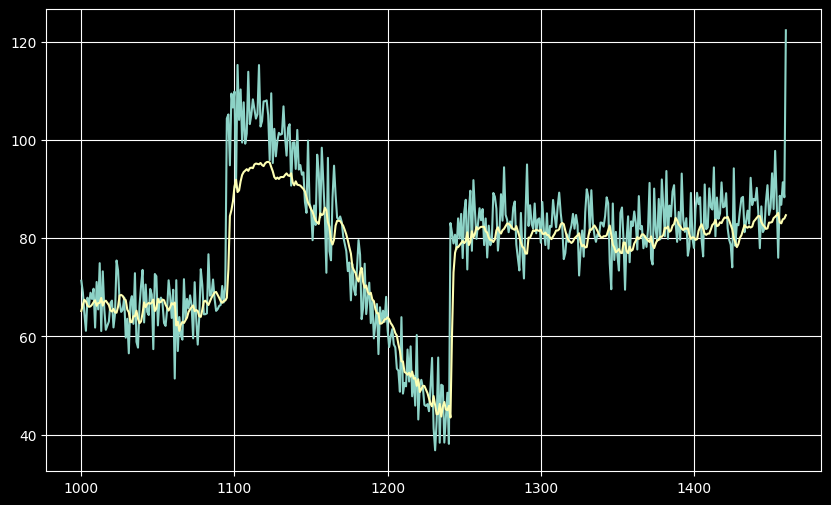

In [23]:
# Reduzir a série original
forecast_series = series[split_time-window_size:-1]

# Use a função auxiliar para gerar previsões
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Descartar eixo unidimensional
results = forecast.squeeze()

# Plotrar os resultados
plot_series(time_valid, (x_valid, results))

As métricas computadas aqui serão ligeiramente diferentes das mostradas na saída de treinamento porque há mais pontos para avaliar. Lembre-se de que `x_valid` tem 461 pontos que correspondem a `t=1000` a `t=1460`. O `val_set` (que é um conjunto de dados janelados do `x_valid`), por outro lado, tem apenas 441 pontos porque não pode gerar previsões para `t=1000` a `t=1019` (ou seja, o janelamento começará aí).

In [24]:
## Calcular o MAE e o MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

54.665863
5.403467


## Resumo

Neste laboratório, você conseguiu criar e treinar um modelo CNN-RNN para previsão. Isso conclui a série de notebooks sobre treinamento com dados sintéticos.

Nos próximos laboratórios, você analisará um conjunto de dados de séries temporais do mundo real, especialmente ciclos de manchas solares!